<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/EuroSAT%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing rasterio to access to geospatial raster data**

In [1]:
pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 78.5 MB/s eta 0:00:00


**Downloading and Extracting EuroSAT dataset**

In [2]:
!wget --no-check-certificate https://madm.dfki.de/files/sentinel/EuroSATallBands.zip -q
!unzip -qq "/content/EuroSATallBands.zip"

In [ ]:
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile
# from subprocess import Popen
# from os import chmod
# from os.path import isfile

**Importing necessary packages**

In [3]:
import os
from fnmatch import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, json, random, itertools, rasterio, math, time, psutil

from tqdm import tqdm
# from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Concatenate)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

# from tensorflow.keras.preprocessing.image import img_to_array, load_img

**Writing helper functions**

In [4]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass


In [5]:
def plot_learning_rate(loss_history):
    
    plt.style.use("ggplot")
    
    plt.plot(np.arange(0,len(loss_history.lr)), loss_history.lr)
    plt.show();
    pass


In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar();
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False);
    pass


**Reading Dataset, Splitting Dataset**

In [8]:
pattern = "*.tif"
def get_files(root):
  files_name = []
  for path, subdirs, files in os.walk(root):
      for name in files:
          if fnmatch(name, pattern):
              files_name.append(os.path.join(path, name))
  return files_name

files = get_files('/content/ds')
dataset = pd.DataFrame({
    'path':files
})
dataset['label'] = dataset['path'].apply(lambda item:str(item).split(r'/')[-1].split('_')[0])
classes = list(set(dataset['label'].to_list()))
mapping = {cls:i for i, cls in enumerate(classes)}
dataset['Label'] = dataset['label'].apply(lambda item:mapping[item])
dataset.head()

,path,label,Label
0,/content/ds/images/remote_sensing/otherDataset...,Highway,2
1,/content/ds/images/remote_sensing/otherDataset...,Highway,2
2,/content/ds/images/remote_sensing/otherDataset...,Highway,2
3,/content/ds/images/remote_sensing/otherDataset...,Highway,2
4,/content/ds/images/remote_sensing/otherDataset...,Highway,2


In [9]:
train_df, test_df = train_test_split(dataset, random_state=42, test_size=.25, stratify=dataset['label'].to_list())
len(train_df), len(test_df)

(20250, 6750)

**Helper Functions for Preparing Data**

In [10]:
def Normalise(arr_band):    
    arr_band = Normalizer().fit_transform(arr_band)
    return arr_band

In [11]:
bands = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'8a':9,'9':10,'10':11,'11':12,'12':13}

In [12]:
def data_generator(df, num_classes, batch_size = 10, target_size = 64):
    i = 0
    classes = set()
    num_samples = df.shape[0]
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples_idx = df.index[offset:offset+batch_size]

            X, y = [], []

            for i in batch_samples_idx:
                img_path = df.loc[i,'path']
                label = df.loc[i,'Label']

                src = rasterio.open(img_path)

                arr_3, arr_4, arr_8 = src.read(bands['3']), src.read(bands['4']), src.read(bands['8']) 
                arr_6, arr_7 = src.read(bands['6']), src.read(bands['7'])
                arr_11 = src.read(bands['11'])

                arr_3 = np.array(arr_3, dtype=np.float32)
                arr_4 = np.array(arr_4, dtype=np.float32)
                arr_6, arr_7 = np.array(arr_6, dtype=np.float32), np.array(arr_7, dtype=np.float32)
                arr_8 = np.array(arr_8, dtype=np.float32)
                arr_11 = np.array(arr_11, dtype=np.float32)

                arr_3 = Normalise(arr_3)
                arr_4 = Normalise(arr_4)
                arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
                arr_8 = Normalise(arr_8)
                arr_11 = Normalise(arr_11)

                bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

                X.append(bands_10_20)
                y.append(label)
                pass

            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes = num_classes)
            
            yield X, y
            pass
        pass
    pass


**Forming Memory-friendly Data Generators**

In [13]:
train_generator = data_generator(train_df, num_classes = 10, batch_size = 10)
val_generator = data_generator(test_df, num_classes = 10, batch_size = 10)

In [14]:
train_labels = train_df.loc[:,'Label']
train_labels = np.array(train_labels)

num_train_samples = train_labels.shape[0]

val_df = test_df
val_labels = val_df.loc[:,'Label']
val_labels = np.array(val_labels)

num_val_samples = val_labels.shape[0]

num_train_samples, num_val_samples

(20250, 6750)

In [15]:
def spectral_block(X,filters,stage,s=1):
    
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1,F2,F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3,3), strides=(s,s), padding='same', name=squeeze_base_name+'c')(X)
    
    X = Concatenate(name="concatenate_"+str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    
    X = Activation("relu", name="spectral"+str(stage))(X)
    
    return X
    pass

**Defining the Model**

In [21]:
def SpectrumNet(input_shape, classes):
    
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1,1), strides=(2,2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16,96,32], 2)
    X = spectral_block(X, [16,96,32], 3)
    X = spectral_block(X, [32,192,64], 4)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32,192,64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64,384,128], 9)
    
    X = Conv2D(10, kernel_size=(1,1), strides=(1,1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8,8), strides=(1,1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    
    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model
    pass

In [22]:
model = SpectrumNet(input_shape = (64,64,6), classes = 10)

In [23]:
model.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 6)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 96)   672         ['input[0][0]']                  
                                                                                                  
 squeeze_2_brancha (Conv2D)     (None, 32, 32, 16)   1552        ['conv1[0][0]']                  
                                                                                                  
 squeeze_2_branchb (Conv2D)     (None, 32, 32, 96)   1632        ['squeeze_2_brancha[0][0]']      
                                                                                        

**Adding Appropriate Callbacks and Classes' Weight**

In [28]:
checkpoint = ModelCheckpoint("6bands_weights_v5-5.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard("6bands-logs", histogram_freq=1)

In [29]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.10
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [30]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))


In [31]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


In [33]:
train_labels_encoded = to_categorical(train_labels,num_classes=10)

classTotals = train_labels_encoded.sum(axis=0)
classWeight = {}

for i in range(len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

# classWeight

In [34]:
opt = SGD(lr=1e-3, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

**Training the Model**

In [35]:
epochs = 150
batchSize = 100

history = model.fit(train_generator,
                   steps_per_epoch = num_train_samples//batchSize,
                   epochs = epochs,
                   verbose = 1,
                   validation_data = val_generator,
                   validation_steps = num_val_samples//batchSize,
                   callbacks = [checkpoint, logs, lrate, loss_history],
                   class_weight = classWeight
                   )


Epoch 1/150
202/202 [==============================] - ETA: 0s - loss: 1.9220 - categorical_accuracy: 0.5342
Epoch 1: val_categorical_accuracy improved from -inf to 0.11642, saving model to 6bands_weights_v5-5.h5
202/202 [==============================] - 36s 103ms/step - loss: 1.9220 - categorical_accuracy: 0.5342 - val_loss: 2.5764 - val_categorical_accuracy: 0.1164 - lr: 0.0010
Epoch 2/150
202/202 [==============================] - ETA: 0s - loss: 1.5290 - categorical_accuracy: 0.6589
Epoch 2: val_categorical_accuracy did not improve from 0.11642
202/202 [==============================] - 20s 99ms/step - loss: 1.5290 - categorical_accuracy: 0.6589 - val_loss: 4.0483 - val_categorical_accuracy: 0.1060 - lr: 0.0010
Epoch 3/150
202/202 [==============================] - ETA: 0s - loss: 1.3643 - categorical_accuracy: 0.6881
Epoch 3: val_categorical_accuracy improved from 0.11642 to 0.18657, saving model to 6bands_weights_v5-5.h5
202/202 [==============================] - 21s 103ms/step 

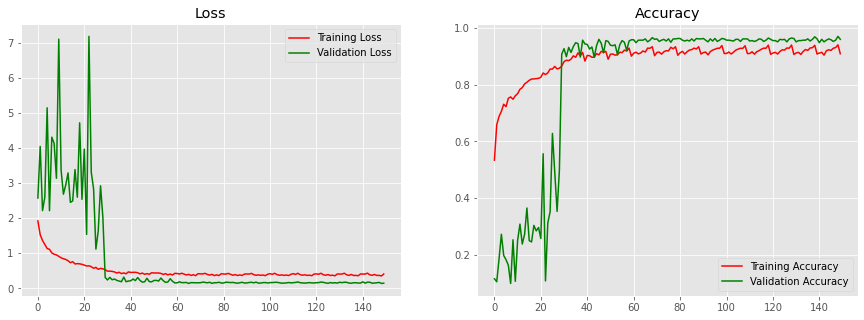

In [36]:
show_final_history(history)

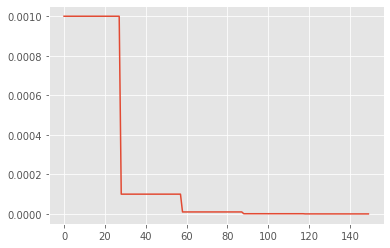

In [37]:
plot_learning_rate(loss_history)

In [62]:
def obtain_tif_images(df):
    
    num_samples = df.shape[0]
    
    X, y = [], []
    
    for i in tqdm(range(num_samples)):
        
        img_name = df.loc[i,'path']
        label = df.loc[i,'Label']
    
        src = rasterio.open(img_name)
        arr_3, arr_4, arr_8 = src.read(bands['3']), src.read(bands['4']), src.read(bands['8']) 
        arr_6, arr_7 = src.read(bands['6']), src.read(bands['7'])
        arr_11 = src.read(bands['11'])

        arr_3 = np.array(arr_3, dtype=np.float32)
        arr_4 = np.array(arr_4, dtype=np.float32)
        arr_6, arr_7 = np.array(arr_6, dtype=np.float32), np.array(arr_7, dtype=np.float32)
        arr_8 = np.array(arr_8, dtype=np.float32)
        arr_11 = np.array(arr_11, dtype=np.float32)

        arr_3 = Normalise(arr_3)
        arr_4 = Normalise(arr_4)
        arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
        arr_8 = Normalise(arr_8)
        arr_11 = Normalise(arr_11)

        bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

        X.append(bands_10_20)
        y.append(label)
        
        pass
    
    X = np.array(X)
    y = np.array(y)
    
    return X,y
    pass

**Inferring Validation Set Again Using Stored/Loaded Model**

In [65]:
test_tifs, test_labels = obtain_tif_images(test_df.reset_index())

test_labels_encoded = to_categorical(test_labels, num_classes = 10)

test_tifs.shape, test_labels.shape, test_labels_encoded.shape

100%|██████████| 6750/6750 [00:49<00:00, 137.06it/s]


((6750, 64, 64, 6), (6750,), (6750, 10))

In [66]:
test_pred = model.predict(test_tifs)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape


211/211 [==============================] - 3s 11ms/step


(6750,)

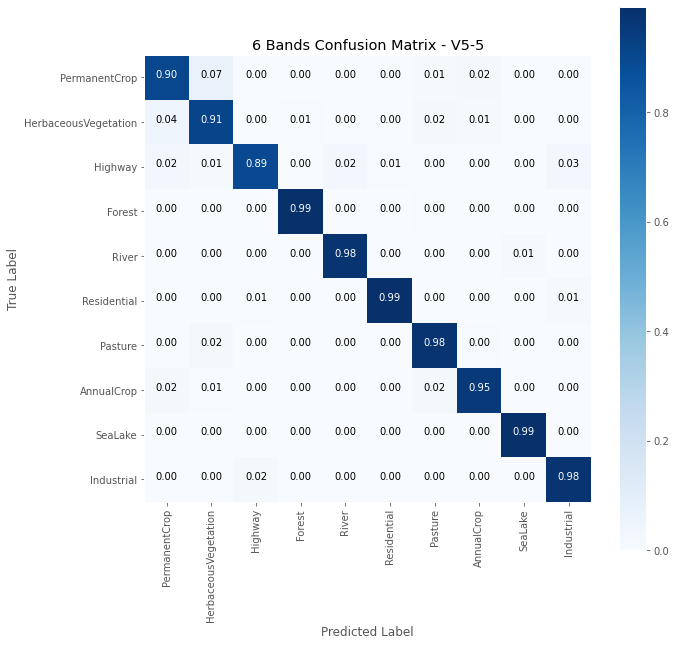

In [67]:
cnf_mat = confusion_matrix(test_labels, test_pred)

plot_confusion_matrix(cnf_mat, classes=list(mapping.keys()), title="6 Bands Confusion Matrix - V5-5")
plt.grid(False);

In [68]:
for f1,class_name in zip(f1_score(test_labels, test_pred, average=None), list(mapping.keys())):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass


Class name: PermanentCrop, F1 score: 0.901
Class name: HerbaceousVegetation, F1 score: 0.913
Class name: Highway, F1 score: 0.930
Class name: Forest, F1 score: 0.991
Class name: River, F1 score: 0.975
Class name: Residential, F1 score: 0.989
Class name: Pasture, F1 score: 0.948
Class name: AnnualCrop, F1 score: 0.956
Class name: SeaLake, F1 score: 0.990
Class name: Industrial, F1 score: 0.967
